# Problem Set 2 - Carbon Fluxes in the Southern Ocean

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cmocean

import gsw
import xarray as xr
import PyCO2SYS as pyco2

In [2]:
# Loading in specific float file
float_id = 5904842
float_file = str(float_id) +'_Sprof.nc'

In [3]:
# Loading in float data
data = xr.open_dataset(float_file)
lon  = data["LONGITUDE"]
lat  = data["LATITUDE"]
press = data["PRES_ADJUSTED"]
temp = data["TEMP_ADJUSTED"]
salt = data["PSAL_ADJUSTED"]
oxy = data["DOXY_ADJUSTED"]
pH = data["PH_IN_SITU_TOTAL_ADJUSTED"]
julian_day = data["JULD"].values
reference_day = np.datetime64('1950-01-01T00:00:00.000000000')
ref_soccom_day = np.datetime64('2017-01-01T00:00:00.000000000')
day_since = julian_day - ref_soccom_day
day_since = day_since/np.timedelta64(1, 'D')
no_profiles = len(day_since)

In [4]:
# You can look at the metadata associated with each variable: i.e.
print(temp)

# You can look at the actual values of the data using:  i.e.
#print(temp.values)

<xarray.DataArray 'TEMP_ADJUSTED' (N_PROF: 155, N_LEVELS: 560)>
[86800 values with dtype=float32]
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    long_name:       Sea temperature in-situ ITS-90 scale
    standard_name:   sea_water_temperature
    units:           degree_Celsius
    valid_min:       -2.5
    valid_max:       40.0
    C_format:        %9.3f
    FORTRAN_format:  F9.3
    resolution:      0.001


In [5]:
# Calculate absolute salinity, conservative temperature and potential density using Gibbs Seawater Toolbox (gsw)
SA = gsw.SA_from_SP(salt,press,lon,lat)
CT = gsw.CT_from_t(SA,temp,press)
sigma0 = gsw.sigma0(SA,CT)

### QUESTION 3: PLOT FLOAT TRAJECTORY

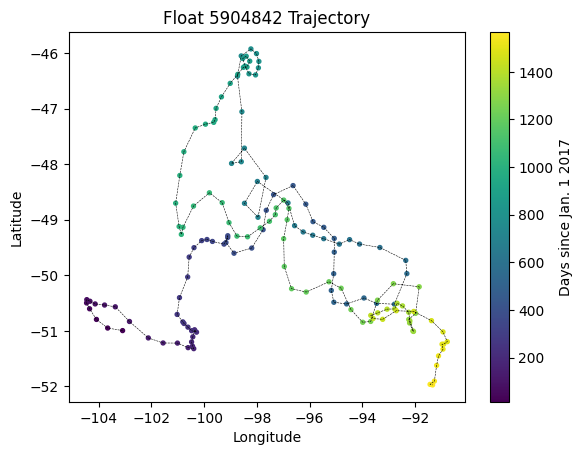

In [6]:
fig_1, ax_1 = plt.subplots()
ax_1.plot(lon,lat,'k',linestyle='dashed',linewidth=0.4)
cl1 = ax_1.scatter(lon,lat,s=32,c=day_since,marker=".")
fig_1.colorbar(cl1,label = "Days since Jan. 1 2017")
ax_1.set_xlabel("Longitude")
ax_1.set_title("Float 5904842 Trajectory")
ax_1.set_ylabel("Latitude");

### QUESTION 4: DEPTH-TIME SECTIONS

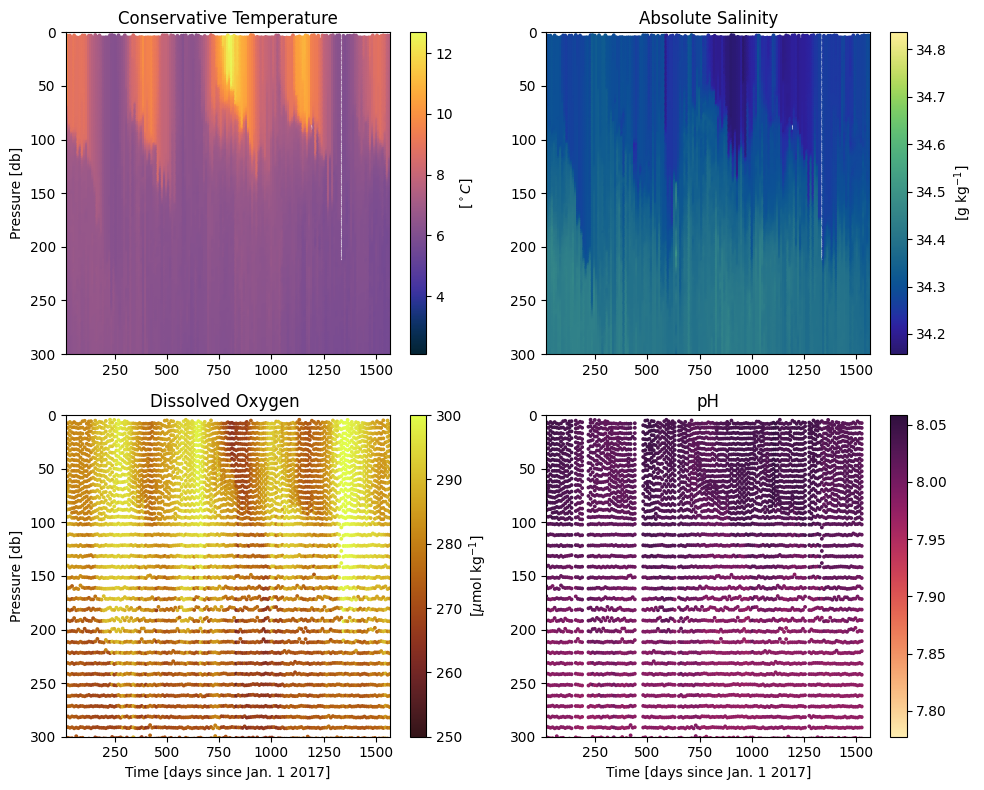

In [7]:
# You can change the maximum depth of the plot here
p_max = 300

fig_2, ax_2 = plt.subplots(2,2,figsize=(10, 8))

X = np.tile(day_since,(np.size(press,1),1)).transpose()

cl2a = ax_2[0,0].scatter(X,press,c=CT,cmap=cmocean.cm.thermal,s=3)
ax_2[0,0].set_ylabel("Pressure [db]")
ax_2[0,0].set_title("Conservative Temperature")
fig_2.colorbar(cl2a,ax=ax_2[0,0],label = "[$^\circ C$]")

cl2b = ax_2[0,1].scatter(X,press,c=SA,cmap=cmocean.cm.haline,s=3)
ax_2[0,1].set_title("Absolute Salinity")
fig_2.colorbar(cl2b,ax=ax_2[0,1],label = "[g kg$^{-1}$]")

cl2c = ax_2[1,0].scatter(X,press,c=oxy,cmap=cmocean.cm.solar,s=3,vmin=250,vmax=300)
ax_2[1,0].set_ylabel("Pressure [db]")
ax_2[1,0].set_xlabel("Time [days since Jan. 1 2017]")
ax_2[1,0].set_title("Dissolved Oxygen ")
fig_2.colorbar(cl2c,ax=ax_2[1,0],label = "[$\mu$mol kg$^{-1}$]")

cl2d = ax_2[1,1].scatter(X,press,c=pH,cmap=cmocean.cm.matter,s=3)
ax_2[1,1].set_xlabel("Time [days since Jan. 1 2017]")
ax_2[1,1].set_title("pH")
fig_2.colorbar(cl2d,ax=ax_2[1,1])

for ax in ax_2.flatten():
    ax.set_ylim(0,p_max)
    ax.set_xlim(np.min(day_since),np.max(day_since))
    ax.invert_yaxis()
    
for ax in fig_2.get_axes():
    ax.label_outer()
fig_2.tight_layout();

### MAKE SCATTER PLOTS OF VARIOUS COMBINATIONS OF PROPERTIES BELOW

### QUESTION 5: CALCULATE AND PLOT THE MLD BELOW

In [11]:
# Calculate the MLD


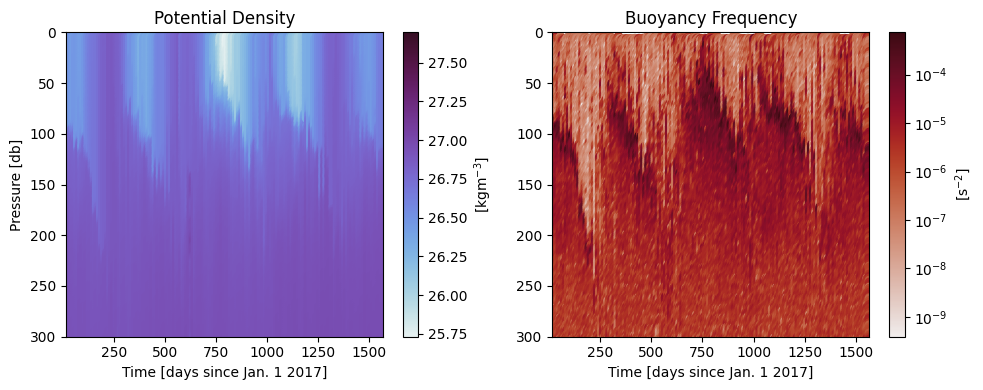

In [12]:
# Plotting MLD onto the density and stratification time series plots
g=9.8
rho0=1026
N2 = np.zeros((len(day_since),np.size(X,1)-3))
for i in range(len(day_since)):
    sigma0_sort = np.sort(sigma0[i,:])
    N2[i,:] = (g/rho0)*(sigma0_sort[2:-1]-sigma0_sort[0:-3])/(press[i,2:-1]-press[i,0:-3])
fig_3, ax_3 = plt.subplots(1,2,figsize=(10, 4))

#UNCOMMENT THESE LINES TO ADD MLD TO PLOT
#ax_3[0].plot(X[:,1],MLD,linewidth=2,c='k')
#ax_3[1].plot(X[:,1],MLD,linewidth=2,c='k')

cl3a = ax_3[0].scatter(X,press,c=sigma0,cmap=cmocean.cm.dense)
fig_3.colorbar(cl3a,ax=ax_3[0],label="[kgm$^{-3}$]")
ax_3[0].set_ylabel("Pressure [db]")
ax_3[0].set_xlabel("Time [days since Jan. 1 2017]")
ax_3[0].set_title("Potential Density")

cl3b = ax_3[1].scatter(X[:,1:-2],press[:,1:-2],c=np.log10(N2),cmap=cmocean.cm.amp)
cbar = fig_3.colorbar(cl3b,ax=ax_3[1],label="[s$^{-2}$]", ticks=[-9,-8,-7,-6,-5,-4,-3])
cbar.ax.set_yticklabels(["10$^{-9}$","10$^{-8}$","10$^{-7}$","10$^{-6}$","10$^{-5}$","10$^{-4}$","10$^{-3}$"])
ax_3[1].set_xlabel("Time [days since Jan. 1 2017]")
ax_3[1].set_title("Buoyancy Frequency")

for ax in ax_3.flatten():
    ax.set_ylim(0,300)
    ax.set_xlim(np.min(day_since),np.max(day_since))
    ax.invert_yaxis()
fig_3.tight_layout();

### CALCULATE THE MEAN AND VARIANCE OF THE MLD BELOW

### QUESTION 6: CALCULATE THE MLD AVERAGE TEMPERATURE, SALINITY, OXYGEN AND pH

In [13]:
temp_mix = np.zeros(len(day_since))
salt_mix = np.zeros(len(day_since))
oxy_mix = np.zeros(len(day_since))
pH_mix = np.zeros(len(day_since))
for i in range(int(len(day_since))):
    kk = np.where(press[i,:]<MLD[i])[0]
    temp_mix[i] = ### Complete this line
    salt_mix[i] = ### Complete this line
    oxy_mix[i]  = ### Complete this line
    pH_mix[i]   = ### Complete this line

SyntaxError: invalid syntax (3128593586.py, line 7)

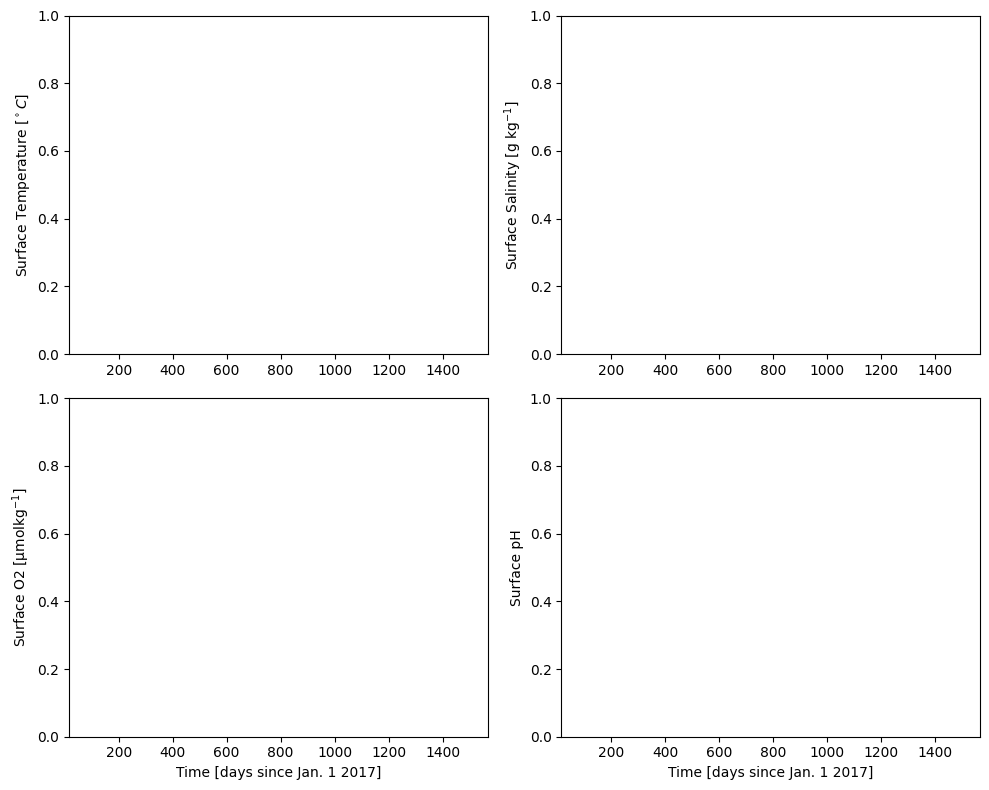

In [14]:
# plotting the time series of the surface properties averaged over the MLD
fig_4, ax_4 = plt.subplots(2,2,figsize=(10, 8))
ax_4[0,0].set_ylabel("Surface Temperature [$^\circ C$]")

ax_4[0,1].set_ylabel("Surface Salinity [g kg$^{-1}$]")

ax_4[1,0].set_ylabel("Surface O2 [μmolkg$^{-1}$]")
ax_4[1,0].set_xlabel("Time [days since Jan. 1 2017]")

ax_4[1,1].set_ylabel("Surface pH")
ax_4[1,1].set_xlabel("Time [days since Jan. 1 2017]")

#UNCOMMENT THESE LINES TO PLOT TIMESERIES
# ax_4[0,0].plot(X[:,1],temp_mix,linewidth=2,c='k')
# ax_4[0,1].plot(X[:,1],salt_mix,linewidth=2,c='b')
# ax_4[1,0].plot(X[:,1],oxy_mix,linewidth=2,c='r')
# ax_4[1,1].plot(X[:,1],pH_mix,linewidth=2,c='g')

for ax in ax_4.flatten():
    ax.set_xlim(np.min(day_since),np.max(day_since))

fig_4.tight_layout()

### QUESTION 7: pCO$_2$ AND CORRELATIONS WITH TEMPERATURE

In [16]:
pyco2_kws = dict()
pyco2_kws["par1_type"] = 1; # The first parameter supplied is of type "1", which is "alkalinity"
pyco2_kws["par1"] = 2300; # value of the first parameter
pyco2_kws["par2_type"] = 3; # The second parameter supplied is of type "2", which is "pH"
pyco2_kws["par2"] = pH_mix; # value of the second parameter, which is a long vector of different pH's!

pyco2_kws["salinity"] = salt_mix;  # Salinity of the sample
pyco2_kws["temperature"] = temp_mix;  # Temperature at input conditions
pyco2_kws["pressure"] = 0;  # Pressure    at input conditions
pyco2_kws["temperature_out"]  = 0;  # Temperature at output conditions - doesn't matter in this example
pyco2_kws["pressure_out"]  =  0;  # Pressure    at output conditions - doesn't matter in this example
pyco2_kws["total_silicate"] =   20;  # Concentration of silicate  in the sample (in umol/kg)
pyco2_kws["total_phosphate"] =    2;  # Concentration of phosphate in the sample (in umol/kg)
pyco2_kws["opt_pH_scale"]  =    1;  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example


pyco2_kws["opt_k_carbonic"] = 4;  #Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")

pyco2_kws["opt_k_bisulfate"] = 1;  #Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

A = pyco2.sys(**pyco2_kws)

NameError: name 'pH_mix' is not defined

### ADD CODE TO LOOK UP VARIOUS TERMS STORED IN A

In [17]:
# Looking up and storing values for the different variables in A
pCO2_oc = ### Complete this line  ###  ### Surface ocean pCO2
DIC_oc = ### Complete this line ###    ### Surface DIC
bicarb = ### Complete this line ###    ### Surface bicarbonate ion concentration
carb = ### Complete this line ###      ### Surface carbonate ion concentration
K0 = ### Complete this line ###        ### Surface solubility

SyntaxError: invalid syntax (4179240578.py, line 2)

### CODE TO PLOT SCATTER GRAPHS OF TEMPERATURE WITH pCO$_2$/K$_0$ AND (BI)CARBONATE TIMESERIES

In [18]:
# Scatter plot of temperature/K0 and temperature/pCO2


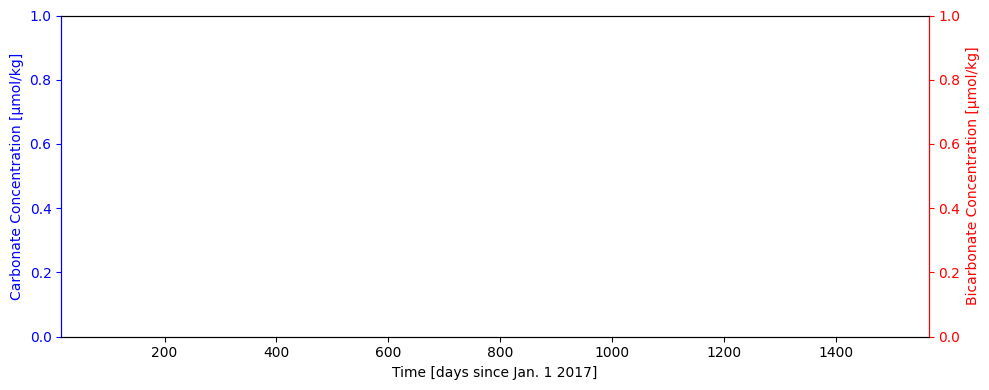

In [19]:
# Time series of bicarbonate and carbonate ion concentrations
fig_5, ax_5 = plt.subplots(1,1,figsize=(10,4))
ax_5.set_ylabel("Carbonate Concentration [μmol/kg]")
ax_5.set_xlim(np.min(day_since),np.max(day_since))
ax_5.spines['left'].set_color('b')
ax_5.yaxis.label.set_color('b')
ax_5.tick_params(axis='y', colors='b')
ax_5.set_xlabel("Time [days since Jan. 1 2017]")

ax_5b = ax_5.twinx()
ax_5b.set_ylabel("Bicarbonate Concentration [μmol/kg]")
ax_5b.spines['right'].set_color('r')
ax_5b.yaxis.label.set_color('red')
ax_5b.tick_params(axis='y', colors='red')
ax_5b.spines['left'].set_color('b')

#UNCOMMENT THESE LINES TO PLOT CARBONATE AND BICARBONATE
#ax_5.plot(X[:,1],carb,linewidth=2,c='b')
#ax_5b.plot(X[:,1],bicarb,linewidth=2,c='r')

fig_5.tight_layout();

### QUESTION 8: ATMOSPHERIC CO$_2$ AT CAPE GRIM

NameError: name 'pCO2_oc' is not defined

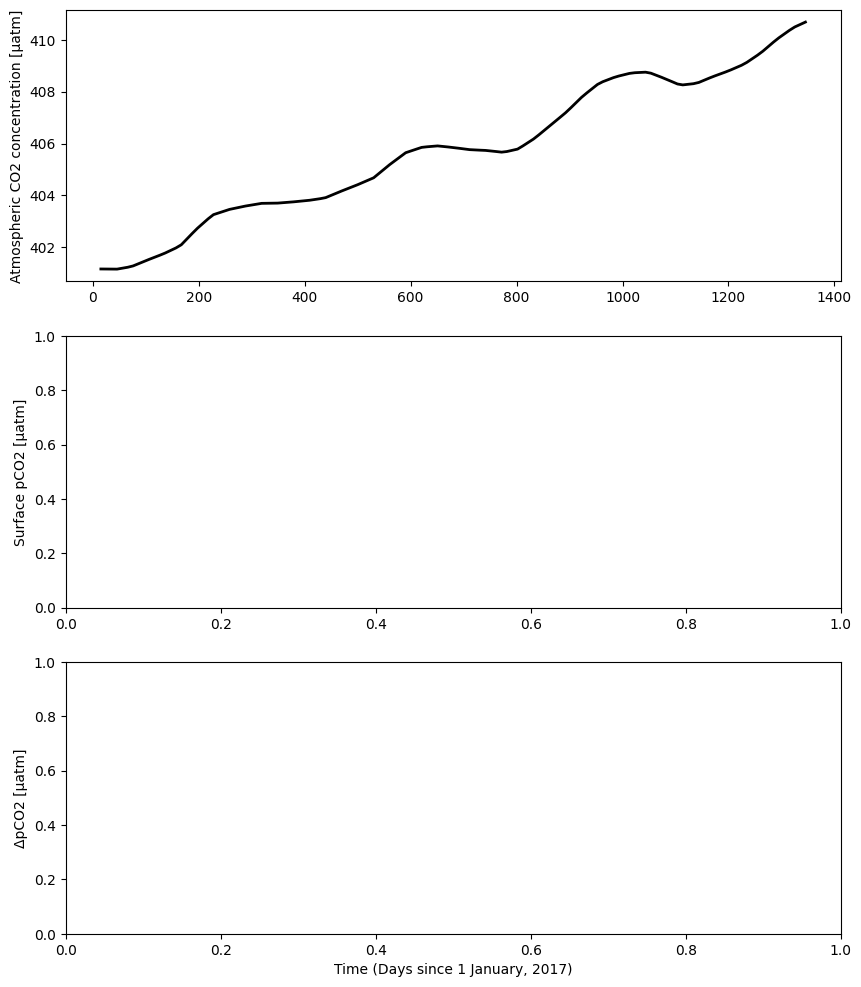

In [20]:
# Load Cape Grim data
A11 = loadmat('CapeGrimRecord.mat')
CapeGrim_time = A11['CapeGrim_time'][0]
CapeGrim_CO2 = A11['CapeGrim_CO2'][0]

# Interpolate atmospheric data to float locations
pCO2_atm = np.empty((no_profiles,1))
pCO2_atm[:] = np.nan
for i in range(int(no_profiles)):
    x = CapeGrim_time
    y = CapeGrim_CO2
    f = interpolate.interp1d(x,y,fill_value=np.nan, bounds_error=False)
    xi = day_since[i]
    pCO2_atm[i] = f(xi)


fig_7, ax_7 = plt.subplots(3,1,figsize=(10, 12))
ax_7[0].set_ylabel("Atmospheric CO2 concentration [μatm]")

ax_7[1].set_ylabel("Surface pCO2 [μatm]")

ax_7[2].set_ylabel("ΔpCO2 [μatm]")
ax_7[2].set_xlabel("Time (Days since 1 January, 2017)")

#UNCOMMENT THESE LINES TO PLOT TIMESERIES
ax_7[0].plot(X[:,1],pCO2_atm,linewidth=2,c='k')
ax_7[1].plot(X[:,1],pCO2_oc,linewidth=2,c='b')
ax_7[2].plot(X[:,1],(pCO2_oc - pCO2_atm[:,0]),linewidth=2,c='g')

for ax in ax_7.flatten():
    ax.set_xlim(np.min(day_since),np.max(day_since))

fig_7.tight_layout()

### CALCULATE MEAN AND VARIANCE OF THE ΔpCO$_2$ TIME SERIES 

### QUESTION 9: CALCULATE THE PISTON VELOCITY BELOW

In [21]:
# Load in ERA5 reanalysis data for the 10 m wind speed interpolated onto float position
ds = loadmat("5904842_Sprof.nc")
speed = ds['speed']

In [32]:
Sc = 660
k =  ### Complete this line  ###

### CALCULATE THE MEAN PISTON VELOCITY AND ITS VARIANCE

### CALCULATE THE CHANGE IN THE MEAN PISTON VELOCITY IF YOU USED THE MEAN WIND SPEED INSTEAD OF INTERPOLATING TO FLOAT TIME/POSITION

### QUESTION 10: CALCULATE THE CO$_2$ FLUX AND PLOT TIME SERIES

In [ ]:
# Calculate CO2 flux


In [56]:
# Plot CO2 flux time series
fig_7, ax_7 = plt.subplots(1,1,figsize=(10, 4))

#UNCOMMENT THIS LINE TO PLOT THE FLUX
#ax_7.plot(X[:,1],F,linewidth=2,c='k')

ax_7.set_ylabel("CO2 Flux [mol m$^{-2}$yr$^{-1}$]")
ax_7.set_xlabel("Time (Days since 1 January, 2017)")
ax_7.set_xlim(np.min(day_since),np.max(day_since))
ax_7.set_ylim(-2,5)

fig_7.tight_layout()

### CALCULATE THE NET GAIN/LOSS OF CARBON DUE TO THIS FLUX OVER THE TIMESERIES IN gCm$^{-2}$

### CALCULATE THE REVELLE FACTOR AND ESTIMATE THE CHANGE IN ML DIC AND pCO2